# Cycle-VQ-GAN by Georg Bernhard

## Introduction

This Notebook implements a pair of Vector Quantized Variational Autoencoders and Adversarial Discriminators to perform cycle-consistent image transformations of a domain "A" to a domain "B" with unpaired training data. The goal is to learn a mapping G:X→Y such that the distribution of images from G(X) is indistinguishable from the distribution Y using an adversarial loss. Because this mapping is highly under-constrained, we couple it with an inverse mapping F:Y→X and introduce a cycle consistency loss to push F(G(X))≈X (and vice versa).


### Dependencies

``` (bash)
conda init
conda create -n cyclevqgan
conda activate cyclevqgan

# Install PyTorch
conda install -y pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
or
conda install -y pytorch torchvision torchaudio cudatoolkit=11.2 -c pytorch -c conda-forge
or
conda install -y pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
or
conda install -y pytorch torchvision torchaudio cpuonly -c pytorch

# Instal other dependencies
conda install -y tqdm matplotlib
conda install -y -c conda-forge notebook nb_conda_kernels ipywidgets ipykernel h5py
pip install albumentations omegaconf nvitop

conda env export > environment.yaml
conda env create --file environment.yaml
```

### Configuration

In [1]:
from omegaconf import OmegaConf

conf = OmegaConf.create(
    """
experiment_name: Spongebob2Simpsons-128-adv-cyc     # Name of experiment
latent_dim: 256                                     # Latent dimension n_z (default: 256)
image_size: 128                                     # Image height and width (default: 256)
num_codebook_vectors: 1024                          # Number of codebook vectors (default: 1024)
beta: 0.25                                          # Commitment loss scalar (default: 0.25)
image_channels: 3                                   # Number of channels of images (default: 3)
dataset_pathfileA: ./trainA.txt                     # Paths for training data A (default: ./trainA.txt)
dataset_pathfileB: ./trainB.txt                     # Paths for training data B (default: ./trainB.txt)
image_repeat: 10                                     # Use n samples from each loaded image (default: 5)
h5filename_train: null                              # Filename for HDF5 file containing all images
batch_size: 4                                       # Input batch size for training (default: 2)
epochs: 500                                         # Number of epochs to train (default: 100)
learning_rate: 0.0005                               # Adam learning rate (default: 0.001) # Cyclegan:0.0002 # VQGAN: 0.00225 # Adam: 0.001
beta1: 0.5                                          # Adam beta1 (default: 0.9)
beta2: 0.999                                        # Adam beta1 (default: 0.999)
adversarial_start: 25000                            # Start adversarial after n steps (default: 25000)
other_loss_start: 50000                             # Start other loss after n steps (default: 50000)
delta: 1.0e-5                                       # delta for numerical stability (default: 1e-6)
loss_factor_vq: 1.0                                 # Factor for vector quantisation loss (default: 1.0)
loss_factor_discriminator: 1.0                      # Factor for discriminator loss (default: 1.0)
loss_factor_other: 0.5                              # Factor for discriminator "other" loss (default: 0.5)
loss_factor_adversarial: 1.0                        # Factor for adversarial loss (default: 1.0)
loss_factor_stability: 0.25                         # Factor for stability loss A->B or B-> A(default: 0.25)
loss_factor_cycle: 1.0                              # Factor for cycle loss A->B->A or B->A->B (default: 1.0)
loss_factor_identity: 0.5                           # Factor for identity loss A->A or B->B (defalut: 0.5)
# loss_factor_perceptual: 1.0                         # Factor for perception loss (defalut: 1.0)
loss_factor_reconstruction: 1.0                     # Factor for combines reconstruction losses (defalut: 1.0)
save_every: 2500                                    # Save every N iterations (default:1500)
sample_every: 100                                   # Sample every N iterations (default: 250)
debug_every: 0                                      # Debug every N iterations (default: 0)
continue_counter: 3216056                           # Counter to continue/load from (default: 0)
continue_epoch: 482                                 # Epoch to continue/load from (default: 0)
checkpoints_dir: ./checkpoints/Spongebob2Simpsons-128-adv-cyc  # Path for saving net states
results_dir: ./results/Spongebob2Simpsons-128-adv-cyc   # Path for saving net states
use_amp: False                                      # Use automatic mixed precision (default: False)
"""
)
print(conf)


{'experiment_name': 'Spongebob2Simpsons-128-adv-cyc', 'latent_dim': 256, 'image_size': 128, 'num_codebook_vectors': 1024, 'beta': 0.25, 'image_channels': 3, 'dataset_pathfileA': './trainA.txt', 'dataset_pathfileB': './trainB.txt', 'image_repeat': 10, 'h5filename_train': None, 'batch_size': 4, 'epochs': 500, 'learning_rate': 0.0005, 'beta1': 0.5, 'beta2': 0.999, 'adversarial_start': 25000, 'other_loss_start': 50000, 'delta': 1e-05, 'loss_factor_vq': 1.0, 'loss_factor_discriminator': 1.0, 'loss_factor_other': 0.5, 'loss_factor_adversarial': 1.0, 'loss_factor_stability': 0.25, 'loss_factor_cycle': 1.0, 'loss_factor_identity': 0.5, 'loss_factor_reconstruction': 1.0, 'save_every': 2500, 'sample_every': 100, 'debug_every': 0, 'continue_counter': 3216056, 'continue_epoch': 482, 'checkpoints_dir': './checkpoints/Spongebob2Simpsons-128-adv-cyc', 'results_dir': './results/Spongebob2Simpsons-128-adv-cyc', 'use_amp': False}


In [2]:
import os

os.makedirs(conf.checkpoints_dir, exist_ok=True)
with open(
    os.path.join(conf.checkpoints_dir, f"{conf.experiment_name}_config.yaml"), "w"
) as fp:
    OmegaConf.save(config=conf, f=fp.name)


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


### Data Utilities

In [4]:
import os
import string
import random

import albumentations
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset


class RandomRepeater(object):
    def __init__(self, image_list, repetitions=5):
        self.i = 0
        self.image_list = image_list
        self.repetitions = repetitions

    def __iter__(self):
        while True:
            self.i = 0
            random.shuffle(self.image_list)
            while self.i < len(self.image_list):
                image = Image.open(self.image_list[self.i])
                if not image.mode == "RGB":
                    image = image.convert("RGB")
                image = np.array(image).astype(np.uint8)
                for n in range(self.repetitions):
                    yield image
                self.i += 1


class CustomImageDataset(Dataset):
    def __init__(
        self,
        size,
        channels,
        paths_A,
        paths_B,
    ):
        self.size = size
        self.channels = channels
        with open(paths_A) as f:
            self.imagesA = [i.strip() for i in f.read().splitlines() if i]
        with open(paths_B) as f:
            self.imagesB = [i.strip() for i in f.read().splitlines() if i]
        self._length = min(len(self.imagesA), len(self.imagesB))
        self.cropper = albumentations.RandomCrop(
            height=self.size, width=self.size, always_apply=True, p=1.0
        )
        self.rotator = albumentations.RandomRotate90(always_apply=False, p=0.5)
        self.preprocessor = albumentations.Compose([self.cropper, self.rotator])
        self.imageA_iter = iter(RandomRepeater(self.imagesA, conf.image_repeat))
        self.imageB_iter = iter(RandomRepeater(self.imagesB, conf.image_repeat))

    def __len__(self):
        return self._length

    def preprocess_image(self, image):
        image = self.preprocessor(image=image)["image"]
        image = (image / 127.5 - 1.0).astype(np.float32)
        image = image.transpose(2, 0, 1)
        image = image[: self.channels, :, :]
        return image

    def __getitem__(self, idx):
        imageA = next(self.imageA_iter)
        imageB = next(self.imageB_iter)
        imageA = self.preprocess_image(imageA)
        imageB = self.preprocess_image(imageB)
        return {
            "A": imageA,
            "B": imageB,
        }


training_loader = DataLoader(
    CustomImageDataset(
        conf.image_size, conf.image_channels, "trainA.txt", "trainB.txt"
    ),
    batch_size=conf.batch_size,
    shuffle=True,
)


A has 33088 items, B has 25777 items
Loader provides 6445 items, batch size is 4
A shape (BCHW): torch.Size([4, 3, 128, 128])
B shape (BCHW): torch.Size([4, 3, 128, 128])


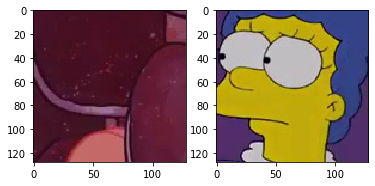

In [5]:
import matplotlib.pyplot as plt
import numpy as np

sample = next(iter(training_loader))

lenA = len(open(conf.dataset_pathfileA).readlines())
lenB = len(open(conf.dataset_pathfileB).readlines())
print(f"A has {lenA} items, B has {lenB} items")
print(f"Loader provides {len(training_loader)} items, batch size is {conf.batch_size}")
print(f'A shape (BCHW): {sample["A"].shape}')
print(f'B shape (BCHW): {sample["B"].shape}')

sample_imageA = (
    (np.transpose(sample["A"][0].add(1).mul(0.5), (1, 2, 0)) * 255)
    .numpy()
    .astype(np.int16)
)
sample_imageB = (
    (np.transpose(sample["B"][0].add(1).mul(0.5), (1, 2, 0)) * 255)
    .numpy()
    .astype(np.int16)
)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(
    sample_imageA,
    interpolation="nearest",
)
axarr[1].imshow(
    sample_imageB,
    interpolation="nearest",
)
display()


### Building Blocks

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(
            num_groups=32, num_channels=channels, eps=1e-6, affine=True
        )

    def forward(self, x):
        return self.gn(x)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            GroupNorm(in_channels),
            Swish(),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            GroupNorm(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        )
        if in_channels != out_channels:
            self.channel_up = nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.channel_up(x) + self.block(x)
        else:
            return x + self.block(x)


class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0)
        return self.conv(x)


class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 2, 0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)


class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels
        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)
        b, c, h, w = q.shape
        q = q.reshape(b, c, h * w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h * w)
        v = v.reshape(b, c, h * w)
        attn = torch.bmm(q, k)
        attn = attn * (int(c) ** (-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)
        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)
        return x + A


### Encoder

In [7]:
import torch.nn as nn

# from helper import ResidualBlock, NonLocalBlock, DownSampleBlock, UpSampleBlock, GroupNorm, Swish


class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        channels = [128, 128, 128, 256, 256, 512]
        attn_resolutions = [16]
        num_res_blocks = 2
        resolution = 256
        layers = [nn.Conv2d(args.image_channels, channels[0], 3, 1, 1)]
        for i in range(len(channels) - 1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels) - 2:
                layers.append(DownSampleBlock(channels[i + 1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], args.latent_dim, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### Decoder

In [8]:
import torch.nn as nn

# from helper import ResidualBlock, NonLocalBlock, UpSampleBlock, GroupNorm, Swish


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        channels = [512, 256, 256, 128, 128]
        attn_resolutions = [16]
        num_res_blocks = 3
        resolution = 16
        in_channels = channels[0]
        layers = [
            nn.Conv2d(args.latent_dim, in_channels, 3, 1, 1),
            ResidualBlock(in_channels, in_channels),
            NonLocalBlock(in_channels),
            ResidualBlock(in_channels, in_channels),
        ]
        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2
        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, args.image_channels, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### Codebook

In [9]:
import torch
import torch.nn as nn


class Codebook(nn.Module):
    def __init__(self, args):
        super(Codebook, self).__init__()
        self.num_codebook_vectors = args.num_codebook_vectors
        self.latent_dim = args.latent_dim
        self.beta = args.beta
        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(
            -1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors
        )

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.latent_dim)
        d = (
            torch.sum(z_flattened**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * (torch.matmul(z_flattened, self.embedding.weight.t()))
        )
        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)
        loss = torch.mean((z_q.detach() - z) ** 2) + self.beta * torch.mean(
            (z_q - z.detach()) ** 2
        )
        z_q = z + (z_q - z).detach()
        z_q = z_q.permute(0, 3, 1, 2)
        return z_q, min_encoding_indices, loss


### Discriminator

In [10]:
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, args, num_filters_last=64, n_layers=3):
        super(Discriminator, self).__init__()
        layers = [
            nn.Conv2d(args.image_channels, num_filters_last, 4, 2, 1),
            nn.LeakyReLU(0.2),
        ]
        num_filters_mult = 1
        for i in range(1, n_layers + 1):
            num_filters_mult_last = num_filters_mult
            num_filters_mult = min(2**i, 8)
            layers += [
                nn.Conv2d(
                    num_filters_last * num_filters_mult_last,
                    num_filters_last * num_filters_mult,
                    4,
                    2 if i < n_layers else 1,
                    1,
                    bias=False,
                ),
                nn.BatchNorm2d(num_filters_last * num_filters_mult),
                nn.LeakyReLU(0.2, True),
            ]
        layers.append(nn.Conv2d(num_filters_last * num_filters_mult, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### VQVAE

In [11]:
import torch
import torch.nn as nn

# from encoder import Encoder
# from decoder import Decoder
# from codebook import Codebook


class VQVAE(nn.Module):
    def __init__(self, args):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(args).to(device=device)
        self.decoder = Decoder(args).to(device=device)
        self.codebook = Codebook(args).to(device=device)
        self.quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(
            device=device
        )
        self.post_quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(
            device=device
        )

    def forward(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(
            quant_conv_encoded_images
        )
        post_quant_conv_mapping = self.post_quant_conv(codebook_mapping)
        decoded_images = self.decoder(post_quant_conv_mapping)

        return decoded_images, codebook_indices, q_loss

    def encode(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(
            quant_conv_encoded_images
        )
        return codebook_mapping, codebook_indices, q_loss

    def decode(self, z):
        post_quant_conv_mapping = self.post_quant_conv(z)
        decoded_images = self.decoder(post_quant_conv_mapping)
        return decoded_images

    def calculate_lambda(self, perceptual_loss, gan_loss, delta=1e-4):
        last_layer = self.decoder.model[-1]
        last_layer_weight = last_layer.weight
        # torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False, is_grads_batched=False)
        perceptual_loss_grads = torch.autograd.grad(
            perceptual_loss,
            last_layer_weight,
            retain_graph=True,
        )[0]
        gan_loss_grads = torch.autograd.grad(
            gan_loss,
            last_layer_weight,
            retain_graph=True,
        )[0]
        lam = torch.norm(perceptual_loss_grads) / (torch.norm(gan_loss_grads) + delta)
        lam = torch.clamp(lam, 0, 1e4).detach()
        return 0.8 * lam

    def load_checkpoint(self, path):
        self.load_state_dict(torch.load(path))


### LPIPS (Perceptual Similarity Metric)

In [12]:
import os
import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple
import requests
from tqdm import tqdm


URL_MAP = {"vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"}
CKPT_MAP = {"vgg_lpips": "vgg.pth"}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path


class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList(
            [
                NetLinLayer(self.channels[0]),
                NetLinLayer(self.channels[1]),
                NetLinLayer(self.channels[2]),
                NetLinLayer(self.channels[3]),
                NetLinLayer(self.channels[4]),
            ]
        )

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(
            torch.load(ckpt, map_location=torch.device("cpu")), strict=False
        )

    def forward(self, real_x, fake_x):
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (
                norm_tensor(features_real[i]) - norm_tensor(features_fake[i])
            ) ** 2

        return sum(
            [
                spatial_average(self.lins[i].model(diffs[i]))
                for i in range(len(self.channels))
            ]
        )


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer(
            "shift", torch.Tensor([-0.030, -0.088, -0.188])[None, :, None, None]
        )
        self.register_buffer(
            "scale", torch.Tensor([0.458, 0.448, 0.450])[None, :, None, None]
        )

    def forward(self, x):
        return (x - self.shift) / self.scale


class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(), nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple(
            "VGGOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3", "relu5_3"]
        )
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)


### Module Utilities

In [13]:
import os
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def plot_images(images):
    x = images["input"]
    reconstruction = images["rec"]
    half_sample = images["half_sample"]
    full_sample = images["full_sample"]

    fig, axarr = plt.subplots(1, 4)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(reconstruction.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[2].imshow(half_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[3].imshow(full_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    plt.show()


def adopt_weight(counter):
    if counter < conf.disc_start:
        return 0.0
    else:
        return conf.disc_factor


def make_filename(modelname, counter=None, epoch=None, postfix=".pt"):
    prefix = conf.checkpoints_dir
    if counter is None and epoch is None:
        filename = os.path.join(
            prefix,
            f"{conf.experiment_name}_{modelname}" + postfix,
        )
    else:
        filename = os.path.join(
            prefix,
            f"{conf.experiment_name}_C{counter:08d}-E{epoch:08d}_{modelname}" + postfix,
        )
    return filename


def save_model_description(instance, name):
    filename = make_filename(name, postfix=".txt")
    with open(filename, "w") as f:
        f.write(repr(instance))


def load_state(instance, **kwargs):
    if "name" in kwargs:
        name = kwargs["name"]
        del kwargs["name"]
    else:
        name = instance.__class__.__name__
    filename = make_filename(name, conf.continue_counter, conf.continue_epoch)
    print(f"Loading state for {name} from {filename}")
    instance.load_state_dict(torch.load(filename))


def save_state(instance, **kwargs):
    if "name" in kwargs:
        name = kwargs["name"]
        del kwargs["name"]
    else:
        name = instance.__class__.__name__
    filename = make_filename(name, kwargs["counter"], kwargs["epoch"])
    if os.path.exists(filename):
        print(f"File {filename!r} exists! Not overwriting!")
        breakpoint()
    else:
        print(f"Saving state for {name} to {filename}")
        torch.save(instance.state_dict(), filename)


def load_Losses(counter, epoch):
    filename = make_filename("loss", counter, epoch)
    print(f"Loading losses from {filename}")
    return torch.load(filename)


def save_losses(losses, counter, epoch):
    filename = make_filename("loss", counter, epoch)
    if os.path.exists(filename):
        print(f"File {filename!r} exists! Not overwriting!")
        breakpoint()
    else:
        print(f"Saving losses into {filename}")
        torch.save(losses, filename)


def value(x):
    return x.cpu().detach().numpy().item()


### VQVAE Trainer

In [14]:
import os
import argparse
from tqdm.notebook import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import utils as vutils
import IPython.display
from torch.nn import Tanh
from statistics import mean


# from discriminator import Discriminator
# from lpips import LPIPS
# from vqgan import VQGAN
# from utils import load_data, weights_init


class TrainVQGAN:
    def __init__(self, args, training_loader=None):
        self.vqvaeAB = VQVAE(args).to(device=device)
        self.vqvaeBA = VQVAE(args).to(device=device)
        self.discriminatorA = Discriminator(args).to(device=device)
        self.discriminatorB = Discriminator(args).to(device=device)
        self.discriminatorA.apply(weights_init)
        self.discriminatorB.apply(weights_init)
        # self.perceptual_loss_AB = LPIPS().eval().to(device=device)
        # self.perceptual_loss_BA = LPIPS().eval().to(device=device)
        (
            self.opt_vqvaes,
            self.opt_discriminators,
        ) = self.configure_optimizers(args)
        self.prepare_training()

        save_model_description(self.vqvaeAB, "vqvaeAB")
        save_model_description(self.vqvaeBA, "vqvaeBA")
        save_model_description(self.discriminatorA, "discriminatorA")
        save_model_description(self.discriminatorB, "discriminatorB")

        self.epoch_start = 0
        self.counter = 0
        self.losses = {}

        if args.continue_epoch or args.continue_counter:
            self.epoch_start = args.continue_epoch
            self.counter = args.continue_counter
            self.load_all_states(counter=self.counter, epoch=self.epoch_start)
            self.load_all_metadata(counter=self.counter, epoch=self.epoch_start)

        self.train(args, training_loader=training_loader)

    def configure_optimizers(self, args):
        lr = args.learning_rate
        betas = (args.beta1, args.beta2)
        opt_vqvaes = torch.optim.Adam(
            list(self.vqvaeAB.encoder.parameters())
            + list(self.vqvaeAB.decoder.parameters())
            + list(self.vqvaeAB.codebook.parameters())
            + list(self.vqvaeAB.quant_conv.parameters())
            + list(self.vqvaeAB.post_quant_conv.parameters())
            + list(self.vqvaeBA.encoder.parameters())
            + list(self.vqvaeBA.decoder.parameters())
            + list(self.vqvaeBA.codebook.parameters())
            + list(self.vqvaeBA.quant_conv.parameters())
            + list(self.vqvaeBA.post_quant_conv.parameters()),
            lr=lr,
            # eps=1e-08,
            betas=betas,
        )
        opt_discriminators = torch.optim.Adam(
            list(self.discriminatorA.parameters())
            + list(self.discriminatorB.parameters()),
            lr=lr,
            # eps=1e-08,
            betas=betas,
        )
        return opt_vqvaes, opt_discriminators

    def print_model_description(self):
        print(self.vqvaeAB)  # , name="VQVAE_AB",)
        print(self.vqvaeBA)  # , name="VQVAE_BA",)
        print(self.discriminatorA)  # , name="DISCR_A",)
        print(self.discriminatorB)  # , name="DISCR_B",)

    def save_all_states(self, counter, epoch):
        save_state(self.vqvaeAB, name="VQVAE_AB", counter=counter, epoch=epoch)
        save_state(self.vqvaeBA, name="VQVAE_BA", counter=counter, epoch=epoch)
        save_state(self.discriminatorA, name="DISCR_A", counter=counter, epoch=epoch)
        save_state(self.discriminatorB, name="DISCR_B", counter=counter, epoch=epoch)

    def load_all_states(self, counter, epoch):
        load_state(self.vqvaeAB, name="VQVAE_AB", counter=counter, epoch=epoch)
        load_state(self.vqvaeBA, name="VQVAE_BA", counter=counter, epoch=epoch)
        load_state(self.discriminatorA, name="DISCR_A", counter=counter, epoch=epoch)
        load_state(self.discriminatorB, name="DISCR_B", counter=counter, epoch=epoch)

    def save_all_metadata(self, counter, epoch):
        save_Losses(self.losses, counter, epoch)

    def load_all_metadata(self, counter, epoch):
        self.losses = load_Losses(counter, epoch)

    @staticmethod
    def prepare_training():
        os.makedirs(conf.results_dir, exist_ok=True)
        os.makedirs(conf.checkpoints_dir, exist_ok=True)

    def train_everything(self, step, imageA, imageB):
        l1 = nn.L1Loss()
        mse = nn.MSELoss()
        sigmoid = nn.Sigmoid()
        tanh = nn.Tanh()
        scaler = torch.cuda.amp.GradScaler(enabled=conf.use_amp)

        with torch.cuda.amp.autocast(enabled=conf.use_amp):
            # Genrate images
            fakes_B, _, loss_vq_fakes_AB = self.vqvaeAB(imageA)
            fakes_A, _, loss_vq_fakes_BA = self.vqvaeBA(imageB)
            cycle_B, _, loss_vq_cycle_AB = self.vqvaeAB(fakes_A)
            cycle_A, _, loss_vq_cycle_BA = self.vqvaeBA(fakes_B)
            ident_B, _, loss_vq_ident_AB = self.vqvaeAB(imageB)
            ident_A, _, loss_vq_ident_BA = self.vqvaeBA(imageA)
            if conf.debug_every and step % conf.debug_every == 0:
                print(
                    f"{fakes_A.shape=} {fakes_B.shape=}"
                    f"{cycle_A.shape=} {cycle_B.shape=}"
                    f"{ident_A.shape=} {ident_B.shape=}"
                )
            
            # Discriminator block
            if step < conf.adversarial_start:
                discriminator_block = 0.0
            else:
                discriminator_block = 1.0

            # Discriminator block
            if step < conf.adversarial_start:
                discriminator_block = 0.0
            else:
                discriminator_block = 1.0

            # Other loss block
            if step < conf.other_loss_start:
                other_loss_block = 0.0
            else:
                other_loss_block = 1.0

            # Discriminators losses
            discriminator_A_reals = self.discriminatorA(imageA)
            discriminator_A_fakes = self.discriminatorA(fakes_A.detach())
            discriminator_A_cycle = self.discriminatorA(cycle_A.detach())
            discriminator_A_other = self.discriminatorA(imageB.detach())
            discriminator_A_reals_loss = mse(
                discriminator_A_reals, torch.ones_like(discriminator_A_reals)
            )
            discriminator_A_fakes_loss = mse(
                discriminator_A_fakes, torch.zeros_like(discriminator_A_fakes)
            )
            discriminator_A_cycle_loss = mse(
                discriminator_A_cycle, torch.zeros_like(discriminator_A_cycle)
            )
            discriminator_A_other_loss = mse(
                discriminator_A_other, torch.zeros_like(discriminator_A_other)
            )
            discriminator_A_losses = torch.mean(
                torch.stack(
                    [
                        discriminator_A_reals_loss,
                        discriminator_A_fakes_loss,
                        discriminator_A_cycle_loss,
                        discriminator_A_other_loss
                        * other_loss_block
                        * conf.loss_factor_other,
                    ]
                )
            )
            discriminator_B_reals = self.discriminatorB(imageB)
            discriminator_B_fakes = self.discriminatorB(fakes_B.detach())
            discriminator_B_cycle = self.discriminatorB(cycle_B.detach())
            discriminator_B_other = self.discriminatorB(imageA.detach())
            discriminator_B_reals_loss = mse(
                discriminator_B_reals, torch.ones_like(discriminator_B_reals)
            )
            discriminator_B_fakes_loss = mse(
                discriminator_B_fakes, torch.zeros_like(discriminator_B_fakes)
            )
            discriminator_B_cycle_loss = mse(
                discriminator_B_cycle, torch.zeros_like(discriminator_B_cycle)
            )
            discriminator_B_other_loss = mse(
                discriminator_B_other, torch.zeros_like(discriminator_B_other)
            )
            discriminator_B_losses = torch.mean(
                torch.stack(
                    [
                        discriminator_B_reals_loss,
                        discriminator_B_fakes_loss,
                        discriminator_B_cycle_loss,
                        discriminator_B_other_loss
                        * other_loss_block
                        * conf.loss_factor_other,
                    ]
                )
            )
            discriminators_losses = torch.mean(
                torch.stack(
                    [
                        discriminator_A_losses,
                        discriminator_B_losses,
                    ]
                )
            )
            if conf.debug_every and step % conf.debug_every == 0:
                print(
                    f"{discriminator_A_reals_loss=} {discriminator_B_reals_loss=}"
                    f"{discriminator_A_fakes_loss=} {discriminator_B_fakes_loss=}"
                    f"{discriminator_A_cycle_loss=} {discriminator_B_cycle_loss=}"
                    f"{discriminator_A_other_loss=} {discriminator_B_other_loss=}"
                    f"{discriminator_A_losses=} {discriminator_B_losses=} {discriminators_losses=}"
                )

            # ------------------------------------------------------------------------------

            # Codebook Losses
            vq_losses_AB = torch.mean(
                torch.stack(
                    [
                        loss_vq_fakes_AB,
                        loss_vq_cycle_AB,
                        loss_vq_ident_AB,
                    ]
                )
            )
            vq_losses_BA = torch.mean(
                torch.stack(
                    [
                        loss_vq_fakes_BA,
                        loss_vq_cycle_BA,
                        loss_vq_ident_BA,
                    ]
                )
            )
            if conf.debug_every and step % conf.debug_every == 0:
                print(
                    f"{loss_vq_fakes_AB=} {loss_vq_fakes_BA=}"
                    f"{loss_vq_cycle_BA=} {loss_vq_cycle_AB=}"
                    f"{loss_vq_ident_AB=} {loss_vq_ident_BA=}"
                    f"{vq_losses_AB=} {vq_losses_BA=}"
                )

            # Adversarial loss
            adversarial_A_fakes = self.discriminatorA(fakes_A)
            adversarial_B_fakes = self.discriminatorB(fakes_B)
            adversarial_A_cycle = self.discriminatorA(cycle_A)
            adversarial_B_cycle = self.discriminatorB(cycle_B)
            loss_adversarial_mse_A_fakes = mse(
                adversarial_A_fakes, torch.ones_like(adversarial_A_fakes)
            )
            loss_adversarial_mse_A_cycle = mse(
                adversarial_A_cycle, torch.ones_like(adversarial_A_cycle)
            )
            loss_adversarial_mse_B_fakes = mse(
                adversarial_B_fakes, torch.ones_like(adversarial_B_fakes)
            )
            loss_adversarial_mse_B_cycle = mse(
                adversarial_B_cycle, torch.ones_like(adversarial_B_cycle)
            )
            losses_adversarial_mse_A = torch.mean(
                torch.stack(
                    [
                        loss_adversarial_mse_A_fakes,
                        loss_adversarial_mse_A_cycle,
                    ]
                )
            )
            losses_adversarial_mse_B = torch.mean(
                torch.stack(
                    [
                        loss_adversarial_mse_B_fakes,
                        loss_adversarial_mse_B_cycle,
                    ]
                )
            )
            if conf.debug_every and step % conf.debug_every == 0:
                print(
                    f"{loss_adversarial_l1_A_fakes=} {loss_adversarial_l1_B_fakes=} {loss_adversarial_l1_A_cycle=} {loss_adversarial_l1_B_cycle=}"
                )
                print(f"{losses_adversarial_l1_A=} {losses_adversarial_l1_B=}")

            # stability_loss
            loss_stability_AB = mse(imageA, fakes_B)
            loss_stability_BA = mse(imageB, fakes_A)
            if conf.debug_every and step % conf.debug_every == 0:
                print(f"{loss_stability_AB=} {loss_stability_BA=}")

            # cycle loss
            loss_cycle_BA = mse(imageA, cycle_A)
            loss_cycle_AB = mse(imageB, cycle_B)
            if conf.debug_every and step % conf.debug_every == 0:
                print(f"{loss_cycle_AB=} {loss_cycle_BA=}")

            # identity loss
            loss_identity_BA = mse(imageA, ident_A)
            loss_identity_AB = mse(imageB, ident_B)
            if conf.debug_every and step % conf.debug_every == 0:
                print(f"{loss_identity_AB=} {loss_identity_BA=}")

            # # perceptual loss
            # loss_perceptual_fakes_AB = torch.abs(
            #     self.perceptual_loss_AB(imageA, fakes_B.detach())
            # )
            # loss_perceptual_fakes_BA = torch.abs(
            #     self.perceptual_loss_BA(imageB, fakes_A.detach())
            # )
            # loss_perceptual_cycle_AB = torch.abs(
            #     self.perceptual_loss_AB(imageB, cycle_B.detach())
            # )
            # loss_perceptual_cycle_BA = torch.abs(
            #     self.perceptual_loss_BA(imageA, cycle_A.detach())
            # )
            # loss_perceptual_AB = torch.mean(
            #     torch.stack([loss_perceptual_fakes_AB, loss_perceptual_cycle_AB])
            # )
            # loss_perceptual_BA = torch.mean(
            #     torch.stack([loss_perceptual_fakes_BA, loss_perceptual_cycle_BA])
            # )
            # if conf.debug_every and step % conf.debug_every == 0:
            #     print(
            #         f"{loss_perceptual_fakes_AB=} {loss_perceptual_fakes_BA=} {loss_perceptual_cycle_AB=} {loss_perceptual_cycle_BA=} {loss_perceptual_AB=} {loss_perceptual_BA=}"
            #     )

            # All reconstruction losses
            losses_reconstruction_BA = torch.mean(
                torch.stack(
                    [
                        loss_stability_BA * conf.loss_factor_stability,
                        loss_cycle_BA * conf.loss_factor_cycle,
                        loss_identity_BA * conf.loss_factor_identity,
                        # loss_perceptual_BA * conf.loss_factor_perceptual,
                    ]
                )
            )
            losses_reconstruction_AB = torch.mean(
                torch.stack(
                    [
                        loss_stability_AB * conf.loss_factor_stability,
                        loss_cycle_AB * conf.loss_factor_cycle,
                        loss_identity_AB * conf.loss_factor_identity,
                        # loss_perceptual_AB * conf.loss_factor_perceptual,
                    ]
                )
            )
            if conf.debug_every and step % conf.debug_every == 0:
                print(f"{losses_reconstruction_AB=} {losses_reconstruction_BA=}")

            # Lambdas
            lambda_BA = (
                self.vqvaeBA.calculate_lambda(
                    losses_reconstruction_BA,
                    losses_adversarial_mse_A,
                )
                * discriminator_block
            )
            lambda_AB = (
                self.vqvaeAB.calculate_lambda(
                    losses_reconstruction_AB,
                    losses_adversarial_mse_B,
                )
                * discriminator_block
            )

            if conf.debug_every and step % conf.debug_every == 0:
                print(f"{lambda_AB=} {lambda_BA=}")

            # All Generator losses
            vqvaes_losses = torch.mean(
                torch.stack(
                    [
                        losses_reconstruction_BA * conf.loss_factor_reconstruction,
                        losses_reconstruction_AB * conf.loss_factor_reconstruction,
                        vq_losses_BA * conf.loss_factor_vq,
                        vq_losses_AB * conf.loss_factor_vq,
                        losses_adversarial_mse_A
                        * conf.loss_factor_adversarial
                        * lambda_BA,
                        losses_adversarial_mse_B
                        * conf.loss_factor_adversarial
                        * lambda_AB,
                    ]
                )
            )

        # Backpropagation
        self.opt_vqvaes.zero_grad()
        self.opt_discriminators.zero_grad()
        scaler.scale(vqvaes_losses).backward()
        scaler.scale(discriminators_losses).backward()
        scaler.step(self.opt_vqvaes)
        scaler.step(self.opt_discriminators)
        scaler.update()

        return {
            "lambda_BA": value(lambda_BA),
            "lambda_AB": value(lambda_AB),
            "loss_adversarial_mse_A_fakes": value(loss_adversarial_mse_A_fakes),
            "loss_adversarial_mse_A_cycle": value(loss_adversarial_mse_A_cycle),
            "losses_adversarial_mse_A": value(losses_adversarial_mse_A),
            "loss_adversarial_mse_B_fakes": value(loss_adversarial_mse_B_fakes),
            "loss_adversarial_mse_B_cycle": value(loss_adversarial_mse_B_cycle),
            "losses_adversarial_mse_B": value(losses_adversarial_mse_B),
            "loss_stability_BA": value(loss_stability_BA),
            "loss_cycle_BA": value(loss_cycle_BA),
            "loss_identity_BA": value(loss_identity_BA),
            # "loss_perceptual_BA": value(loss_perceptual_BA),
            "loss_stability_AB": value(loss_stability_AB),
            "loss_cycle_AB": value(loss_cycle_AB),
            "loss_identity_AB": value(loss_identity_AB),
            # "loss_perceptual_AB": value(loss_perceptual_AB),
            "losses_reconstruction_BA": value(losses_reconstruction_BA),
            "losses_reconstruction_AB": value(losses_reconstruction_AB),
            "vq_losses_BA": value(vq_losses_BA),
            "vq_losses_AB": value(vq_losses_AB),
            "discriminator_A_reals_loss": value(discriminator_A_reals_loss),
            "discriminator_A_fakes_loss": value(discriminator_A_fakes_loss),
            "discriminator_A_cycle_loss": value(discriminator_A_cycle_loss),
            "discriminator_A_other_loss": value(discriminator_A_other_loss),
            "discriminator_B_reals_loss": value(discriminator_B_reals_loss),
            "discriminator_B_fakes_loss": value(discriminator_B_fakes_loss),
            "discriminator_B_cycle_loss": value(discriminator_B_cycle_loss),
            "discriminator_B_other_loss": value(discriminator_B_other_loss),
            "discriminator_A_losses": value(discriminator_A_losses),
            "discriminator_B_losses": value(discriminator_B_losses),
            "vqvaes_losses": value(vqvaes_losses),
            "discriminators_losses": value(discriminators_losses),
        }

    def train(self, args, training_loader=None):
        plot_lookback = 10 * len(training_loader)
        plot_keys = [
            # "lambda_BA",
            # "lambda_AB",
            # "loss_adversarial_mse_A_fakes",
            # "loss_adversarial_mse_A_cycle",
            "losses_adversarial_mse_A",
            # "loss_adversarial_A",
            # "loss_adversarial_mse_B_fakes",
            # "loss_adversarial_mse_B_cycle",
            "losses_adversarial_mse_B",
            # "loss_adversarial_B",
            # "loss_stability_BA",
            # "loss_cycle_BA",
            # "loss_identity_BA",
            # "loss_perceptual_BA",
            # "loss_stability_AB",
            # "loss_cycle_AB",
            # "loss_identity_AB",
            # "loss_perceptual_AB",
            "losses_reconstruction_BA",
            "losses_reconstruction_AB",
            "vq_losses_BA",
            "vq_losses_AB",
            # "discriminator_A_reals_loss",
            # "discriminator_A_fakes_loss",
            # "discriminator_A_cycle_loss",
            # "discriminator_A_other_loss",
            # "discriminator_B_reals_loss",
            # "discriminator_B_fakes_loss",
            # "discriminator_B_cycle_loss",
            # "discriminator_B_other_loss",
            "discriminator_A_losses",
            "discriminator_B_losses",
            # "vqvaes_losses",
            # "discriminators_losses",
        ]
        initial = self.counter % len(training_loader)
        for epoch in range(self.epoch_start, args.epochs):
            with tqdm(
                iterable=range(len(training_loader)),
                initial=initial,
            ) as pbar:
                for i, imgs in zip(pbar, training_loader):
                    if i + initial > len(training_loader):
                        pbar.close()
                        initial = 0
                        break
                    imageA = imgs["A"].to(device=device)
                    imageB = imgs["B"].to(device=device)

                    new_losses = self.train_everything(self.counter, imageA, imageB)

                    for key in new_losses.keys():
                        try:
                            self.losses[key].append(new_losses[key])
                        except KeyError:
                            self.losses[key] = [new_losses[key]]

                    # Samples and statistics
                    if self.counter % args.sample_every == 0:
                        with torch.no_grad():
                            fakes_B, _, _ = self.vqvaeAB(imageA)
                            fakes_A, _, _ = self.vqvaeBA(imageB)
                            cycle_B, _, _ = self.vqvaeAB(fakes_A)
                            cycle_A, _, _ = self.vqvaeBA(fakes_B)

                            summary_images_A = torch.cat(
                                (
                                    imageA.add(1).mul(0.5),
                                    fakes_B.add(1).mul(0.5),
                                    cycle_A.add(1).mul(0.5),
                                )
                            )
                            summary_images_B = torch.cat(
                                (
                                    imageB.add(1).mul(0.5),
                                    fakes_A.add(1).mul(0.5),
                                    cycle_B.add(1).mul(0.5),
                                )
                            )
                            filenameA = os.path.join(
                                args.results_dir,
                                f"{args.experiment_name}_{self.counter:08d}-{epoch:08d}_A.jpg",
                            )
                            filenameB = os.path.join(
                                args.results_dir,
                                f"{args.experiment_name}_{self.counter:08d}-{epoch:08d}_B.jpg",
                            )
                            vutils.save_image(
                                summary_images_A, filenameA, nrow=args.batch_size
                            )
                            vutils.save_image(
                                summary_images_B, filenameB, nrow=args.batch_size
                            )
                        IPython.display.clear_output()
                        imgA = Image.open(filenameA)
                        imgB = Image.open(filenameB)
                        imgAandB = Image.new("RGB", (imgA.width * 2, imgA.height))
                        imgAandB.paste(imgA, (0, 0))
                        imgAandB.paste(imgB, (imgA.width, 0))
                        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
                        fig.tight_layout()
                        ax1.imshow(imgAandB)
                        ax1.set_xticklabels([])
                        ax1.set_yticklabels([])
                        ax1.axis("off")
                        plt.yscale("symlog")
                        # ax2.set_ylim()
                        # num_plots = len( self.losses.keys())
                        # colormap = plt.cm.gist_ncar
                        # plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))
                        handles = []
                        labels = []
                        for key in plot_keys:
                            ax2.plot(
                                self.losses[key][-plot_lookback:],
                            )
                            labels.append(
                                key.replace("_losses", "").replace("losses_", "")
                            )
                        ax2.get_xaxis().set_visible(False)
                        ax2.legend(labels, ncol=4, loc="upper center")
                        plt.show()

                        display(pbar.container)

                    # Show progress
                    if self.counter < conf.adversarial_start:
                        discriminator_block = "disc🚫"
                    else:
                        discriminator_block = ""

                    if self.counter < conf.other_loss_start:
                        other_loss_block = "other🚫"
                    else:
                        other_loss_block = ""
                    pbar.set_postfix(
                        Bs=f"{discriminator_block}{other_loss_block}",
                        E=f"{epoch}/{args.epochs-1}",
                        C=f"{self.counter}",
                        disc=f"{new_losses['discriminators_losses']:0.4f}",
                        vqvae=f"{new_losses['vqvaes_losses']:0.4f}",
                    )
                    pbar.update(0)

                    # Save model
                    if (
                        self.counter % args.save_every == 0
                        and self.counter != 0
                        and self.counter != args.continue_counter
                    ):
                        self.save_all_states(self.counter, epoch)
                        save_losses(self.losses, counter=self.counter, epoch=epoch)

                    self.counter += 1

                # Save model (end of epoch)
                self.save_all_states(self.counter, epoch)
                save_losses(self.losses, counter=self.counter, epoch=epoch)


### Start Training!

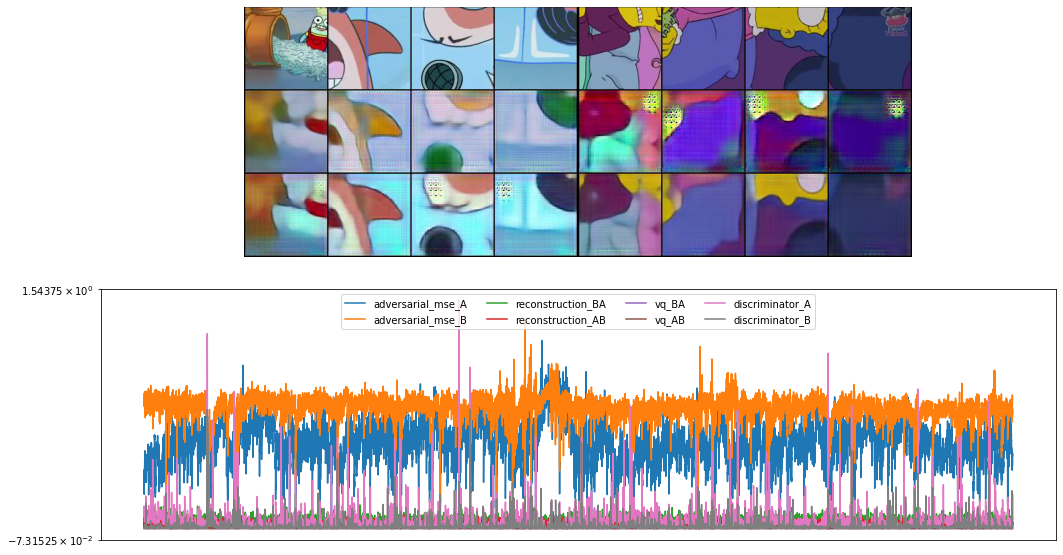

 99%|#########8| 6380/6445 [1:41:53<00:58,  1.11it/s, Bs=, C=3331999, E=499/499, disc=0.0356, vqvae=0.1048]

Saving state for VQVAE_AB to ./checkpoints/Spongebob2Simpsons-128-adv-cyc/Spongebob2Simpsons-128-adv-cyc_C03332066-E00000499_VQVAE_AB.pt
Saving state for VQVAE_BA to ./checkpoints/Spongebob2Simpsons-128-adv-cyc/Spongebob2Simpsons-128-adv-cyc_C03332066-E00000499_VQVAE_BA.pt
Saving state for DISCR_A to ./checkpoints/Spongebob2Simpsons-128-adv-cyc/Spongebob2Simpsons-128-adv-cyc_C03332066-E00000499_DISCR_A.pt
Saving state for DISCR_B to ./checkpoints/Spongebob2Simpsons-128-adv-cyc/Spongebob2Simpsons-128-adv-cyc_C03332066-E00000499_DISCR_B.pt
Saving losses into ./checkpoints/Spongebob2Simpsons-128-adv-cyc/Spongebob2Simpsons-128-adv-cyc_C03332066-E00000499_loss.pt


In [15]:
train_vqgan = TrainVQGAN(conf, training_loader=training_loader)
    